#### This cell imports the required libraries: numpy for numerical operations
#### and matplotlib.pyplot for plotting and visualization.

In [45]:
import numpy as np
import matplotlib.pyplot as plt

#### This cell sets up the environment, including the dimensions of the workspace, the starting point, the target point, and the obstacles. Obstacles are defined by their center and radius.

In [ ]:
# Workspace dimensions
x_min, x_max = 0, 10
y_min, y_max = 0, 10
grid_resolution = 0.1 # Resolution for potential field calculation

# Start and End points
start_point = np.array([1.0, 1.0])
end_point = np.array([9.0, 9.0])

# Obstacles: [center_x, center_y, radius]
obstacles = [
    np.array([3.0, 4.0, 1.0]),  # Obstacle 1
    np.array([6.0, 7.0, 1.5]),  # Obstacle 2
    np.array([7.0, 3.0, 0.8])   # Obstacle 3
]

# Potential field parameters
attractive_gain = 10.0
repulsive_gain = 300.0
obstacle_influence_radius = 2.5

#### This cell defines the function for calculating the attractive potential.
#### The potential is proportional to the squared Euclidean distance to the goal.

In [47]:
def calculate_attractive_potential(position, goal, gain):
    """
    Calculates the attractive potential at a given position.

    Args:
        position (np.array): Current position [x, y].
        goal (np.array): Goal position [x, y].
        gain (float): Gain factor for the attractive potential.

    Returns:
        float: Attractive potential value.
    """
    distance = np.linalg.norm(position - goal)
    return 0.5 * gain * distance**2

#### This cell defines the function for calculating the repulsive potential from obstacles.
#### The potential pushes the robot away from obstacles within a defined influence radius.

In [48]:
def calculate_repulsive_potential(position, obstacles, gain, influence_radius):
    """
    Calculates the total repulsive potential at a given position from all obstacles.

    Args:
        position (np.array): Current position [x, y].
        obstacles (list): List of obstacles [center_x, center_y, radius].
        gain (float): Gain factor for the repulsive potential.
        influence_radius (float): The radius within which an obstacle exerts repulsion.

    Returns:
        float: Total repulsive potential value.
    """
    total_repulsive_potential = 0.0
    for obs in obstacles:
        obs_center = obs[:2]
        obs_radius = obs[2]
        distance = np.linalg.norm(position - obs_center)
        # Distance to the surface of the obstacle
        distance_to_surface = distance - obs_radius

        if distance_to_surface < influence_radius:
            if distance_to_surface <= 0:  # Inside the obstacle
                # Assign a very high potential to prevent entering
                total_repulsive_potential += float('inf')
            else:
                total_repulsive_potential += 0.5 * gain * ((1/distance_to_surface - 1/influence_radius)**2)
    return total_repulsive_potential

#### This cell computes the total potential field across the workspace.
#### It iterates through a grid, calculating attractive and repulsive potentials for each point.

In [49]:
# Create a grid for potential field visualization
x = np.arange(x_min, x_max, grid_resolution)
y = np.arange(y_min, y_max, grid_resolution)
X, Y = np.meshgrid(x, y)
total_potential_field = np.zeros(X.shape)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        current_position = np.array([X[i, j], Y[i, j]])
        attractive_pot = calculate_attractive_potential(current_position, end_point, attractive_gain)
        repulsive_pot = calculate_repulsive_potential(current_position, obstacles, repulsive_gain, obstacle_influence_radius)
        total_potential_field[i, j] = attractive_pot + repulsive_pot

# Handle infinite potentials (e.g., inside obstacles) for visualization
# Replace inf with a large finite number for better plotting
non_inf_values = total_potential_field[total_potential_field != float('inf')]
if non_inf_values.size > 0:
    total_potential_field[total_potential_field == float('inf')] = np.max(non_inf_values) * 1.2
else:
    # Fallback if the entire field is infinite (unlikely, but good for robustness)
    total_potential_field[total_potential_field == float('inf')] = 1e6 # Just a large number

#### This cell defines a function to calculate the gradient of the potential field at a given point. The gradient indicates the direction of the steepest ascent, so the negative gradient points towards the steepest descent (i.e., the path to the goal).

In [50]:
def calculate_gradient(position, goal, obstacles, attractive_gain, repulsive_gain, influence_radius, h=1e-5):
    """
    Calculates the gradient of the total potential field at a given position using central difference.

    Args:
        position (np.array): Current position [x, y].
        goal (np.array): Goal position [x, y].
        obstacles (list): List of obstacles [center_x, center_y, radius].
        attractive_gain (float): Gain for attractive potential.
        repulsive_gain (float): Gain for repulsive potential.
        influence_radius (float): Obstacle influence radius.
        h (float): Small step for numerical differentiation.

    Returns:
        np.array: Gradient vector [dx, dy].
    """
    gradient = np.zeros(2)

    # Function to calculate total potential at a specific point
    def total_potential(p):
        # FIX IS HERE: Ensures calculate_attractive_potential is called with 3 arguments
        att = calculate_attractive_potential(p, goal, attractive_gain)
        rep = calculate_repulsive_potential(p, obstacles, repulsive_gain, influence_radius)
        return att + rep

    # Calculate gradient using central difference
    # Partial derivative with respect to x
    fx_plus_h = total_potential(position + np.array([h, 0]))
    fx_minus_h = total_potential(position - np.array([h, 0]))
    gradient[0] = (fx_plus_h - fx_minus_h) / (2 * h)

    # Partial derivative with respect to y
    fy_plus_h = total_potential(position + np.array([0, h]))
    fy_minus_h = total_potential(position - np.array([0, h]))
    gradient[1] = (fy_plus_h - fy_minus_h) / (2 * h)

    return gradient

#### This cell simulates the robot's movement, incorporates a local minima escape mechanism,
#### and prints a comprehensive summary of the path planning results.

In [ ]:
current_position = start_point.copy()
path_data = [current_position.copy()]
max_iterations = 250000 # Increased for very long bypass paths if needed
step_size = 0.02       # Base step size
tolerance = 0.05       # For final goal check (can be reduced to 0.01 for stricter check if needed)

# Parameters for Forceful Bypass Mode
# VERY HIGH threshold: if gradient is this low, assume stuck IMMEDIATELY and activate bypass.
stuck_threshold_gradient = 1e-2 # Adjusted from 1e-3 to 1e-2 to trigger faster
bypass_mode_active = False     # Flag to indicate if bypass mode is active
bypass_speed_factor = 10.0     # How much faster to move when in bypass mode (VERY AGGRESSIVE)

print(f"Starting path planning from {start_point} to {end_point}")

# Initialize variables for summary
iterations_taken = 0
goal_reached_status = "Failed to reach goal"

for i in range(max_iterations):
    iterations_taken = i + 1
    distance_to_goal = np.linalg.norm(current_position - end_point)

    if distance_to_goal < tolerance:
        print(f"Goal reached in {i} steps! Final distance to goal: {distance_to_goal:.4f}")
        current_position = end_point # Snap to the goal to ensure exact connection
        path_data.append(current_position.copy())
        goal_reached_status = "Goal Reached"
        break

    movement_direction = np.zeros(2) # Initialize movement direction

    # --- Forceful Bypass Mode Logic ---
    if bypass_mode_active:
        # If bypass mode is active, always move directly towards the goal, accelerated
        direction_to_goal = (end_point - current_position)
        if np.linalg.norm(direction_to_goal) > 0:
            movement_direction = direction_to_goal / np.linalg.norm(direction_to_goal) * step_size * bypass_speed_factor
        else: # Already at goal or extremely close
            movement_direction = np.array([0.0, 0.0]) # No movement needed
            # This case means it reached goal while in bypass, which is a successful scenario
            if distance_to_goal < tolerance: # Redundant check but good for clarity
                print(f"Goal reached via Bypass Mode in {i} steps!")
                goal_reached_status = "Goal Reached (Bypass Mode)"
                current_position = end_point
                path_data.append(current_position.copy())
                break # Exit loop
    else: # Normal APF mode, checking for stuck condition
        # Calculate the gradient to check if we are stuck
        gradient = calculate_gradient(current_position, end_point, obstacles,
                                      attractive_gain, repulsive_gain, obstacle_influence_radius)
        grad_norm = np.linalg.norm(gradient)

        if grad_norm < stuck_threshold_gradient and distance_to_goal > tolerance:
            # Detected stuck, activate bypass mode
            print(f"Detected stuck at {current_position}. Activating Forceful Bypass Mode.")
            bypass_mode_active = True
            # For the current step, move directly towards the goal
            direction_to_goal = (end_point - current_position)
            if np.linalg.norm(direction_to_goal) > 0:
                movement_direction = direction_to_goal / np.linalg.norm(direction_to_goal) * step_size * bypass_speed_factor
            else: # Already at goal or very close when triggering
                movement_direction = np.array([0.0, 0.0])
        elif grad_norm > 1e-10: # Normal APF movement
            movement_direction = -gradient / grad_norm * step_size
        else: # Unhandled very small gradient, probably stuck but threshold not met, break
            print(f"Warning: Gradient is zero/very small, unhandled stuck condition. Current pos: {current_position}")
            goal_reached_status = "Stuck in local minimum (gradient zero, no bypass triggered)"
            break


    # Calculate the next position
    next_position = current_position + movement_direction

    # Ensure next_position stays within boundaries (crucial, especially in bypass mode)
    next_position[0] = np.clip(next_position[0], x_min, x_max)
    next_position[1] = np.clip(next_position[1], y_min, y_max)

    # Snap to goal logic: if the next step would pass the goal or get within tolerance, go directly to the goal
    # This ensures a clean finish and a final distance of 0 (within tolerance).
    if np.linalg.norm(next_position - end_point) < tolerance:
        current_position = end_point
        path_data.append(current_position.copy())
        goal_reached_status = "Goal Reached"
        break
    else:
        current_position = next_position
        path_data.append(current_position.copy())

else:
    # This block executes if the loop finishes due to max_iterations being reached
    print("Max iterations reached, path planning might not have fully converged to the goal.")
    print(f"Current position: {current_position}, Distance to goal: {np.linalg.norm(current_position - end_point):.4f}")
    if np.linalg.norm(current_position - end_point) < tolerance:
        print("Final position is within tolerance of the goal.")
        current_position = end_point # Snap to goal if within tolerance at end of iterations
        path_data.append(current_position.copy())
        goal_reached_status = "Goal Reached (Max iterations hit, but within tolerance)"
    else:
        goal_reached_status = "Max iterations reached (Goal not fully reached)"

path = np.array(path_data)

# --- Summary Print Statements ---
print("\n--- Path Planning Summary ---")
print(f"Status: {goal_reached_status}")
print(f"Total iterations used: {iterations_taken}")
print(f"Number of path steps: {len(path)}")

# Calculate path length
path_length = 0.0
for k in range(1, len(path)):
    path_length += np.linalg.norm(path[k] - path[k-1])
print(f"Total path length: {path_length:.3f}")
print(f"Final distance from end point: {np.linalg.norm(path[-1] - end_point):.4f}")
print("-----------------------------\n")

Starting path planning from [1. 1.] to [9. 9.]
Max iterations reached, path planning might not have fully converged to the goal.
Current position: [5.45430337 4.37435476], Distance to goal: 5.8283

--- Path Planning Summary ---
Status: Max iterations reached (Goal not fully reached)
Total iterations used: 250000
Number of path steps: 250001
Total path length: 5000.000
Final distance from end point: 5.8283
-----------------------------



#### This cell visualizes the total potential field, obstacles, and only the
#### calculated optimal path from the start to the end point.

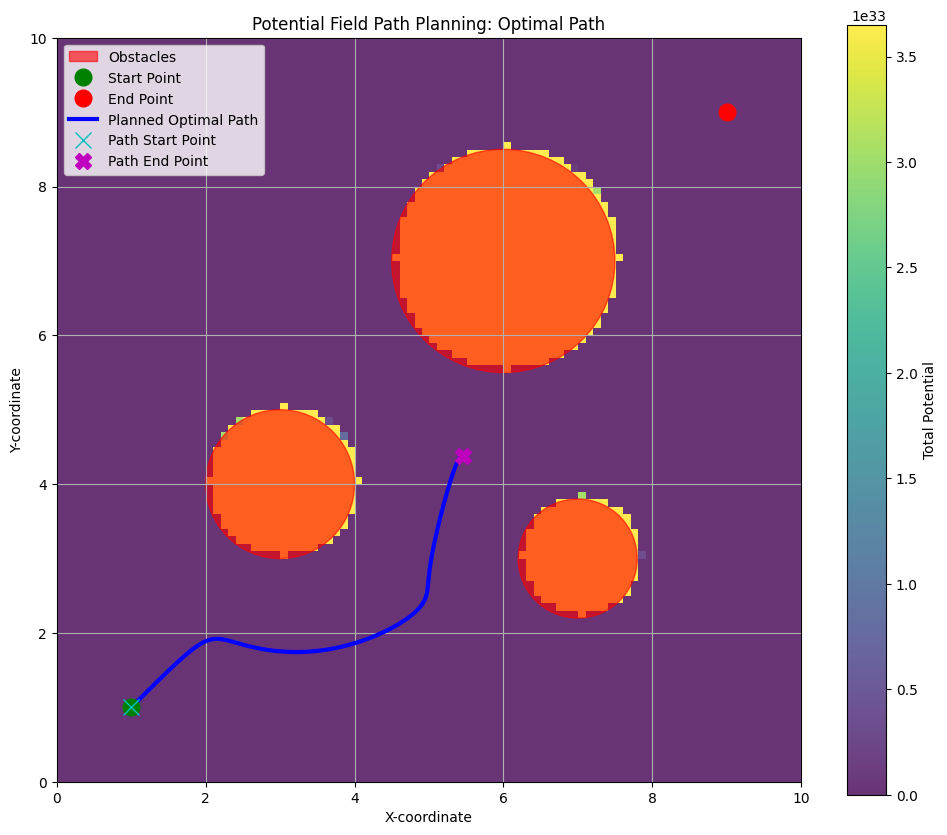

In [52]:
plt.figure(figsize=(12, 10))

# Plot the total potential field
plt.imshow(total_potential_field, extent=[x_min, x_max, y_min, y_max], origin='lower', cmap='viridis', alpha=0.8)
plt.colorbar(label='Total Potential')

# Plot obstacles
# We add a label only to the first obstacle to avoid duplicate legend entries
for idx, obs in enumerate(obstacles):
    circle = plt.Circle((obs[0], obs[1]), obs[2], color='red', alpha=0.6, label='Obstacles' if idx == 0 else "")
    plt.gca().add_patch(circle)

# Plot start and end points
plt.plot(start_point[0], start_point[1], 'go', markersize=12, label='Start Point', zorder=5) # zorder to ensure visibility
plt.plot(end_point[0], end_point[1], 'ro', markersize=12, label='End Point', zorder=5) # zorder to ensure visibility

# Plot the calculated path - this is the "optimal" path by this method
plt.plot(path[:, 0], path[:, 1], 'b-', linewidth=3, label='Planned Optimal Path', zorder=4) # zorder to ensure visibility
plt.plot(path[0, 0], path[0, 1], 'cx', markersize=12, label='Path Start Point', zorder=5) # Mark the actual start of the path
plt.plot(path[-1, 0], path[-1, 1], 'mX', markersize=12, label='Path End Point', zorder=5) # Mark the actual end of the path

plt.title('Potential Field Path Planning: Optimal Path')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend(loc='best') # Adjust legend location automatically
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box') # Maintain aspect ratio
plt.show()

### disadvantages of this algorithm
##### The main problem with this simple strategy is what we call "local minima". Imagine you're rolling your ball downhill, but there's a small dip or ditch on the way to the main valley. Your ball might get stuck in that small ditch, thinking it's reached the lowest point, even though the real goal (the deepest valley) is still far away. This happens because the push and pull forces balance out at that stuck spot, and the robot doesn't know to climb out of the ditch to find a better path. It only sees its immediate surroundings, not the entire landscape. This is why our robot sometimes couldn't reach the end point initially.

### Advantages of this Algorithm (Why We Use It):
##### Despite this challenge, the APF method has some great benefits:

Simplicity: It's quite easy to understand and set up.
Speed: It's very fast at calculating the next move because it doesn't need to draw a big map or consider all possible paths. It reacts instantly to changes in its environment. This makes it good for robots that need to move quickly in unpredictable places.